#  Forecasting Simulated Data With An Ensemble of Exponential Smoothing Models

In [151]:
from darts.utils import timeseries_generation
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
import pandas as pd
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import time

# Simulate Time series

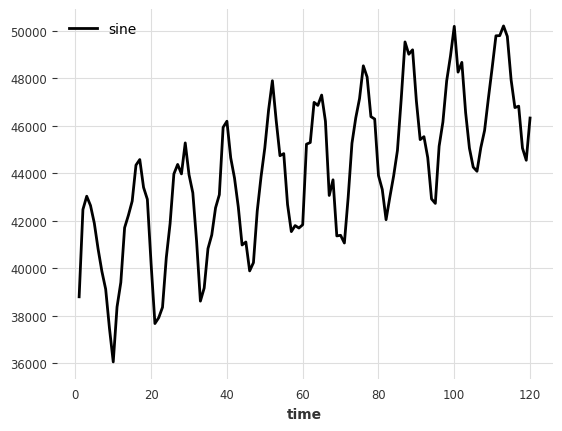

In [32]:
start_id = 1
len_timeseries = 12*10
season_ts = timeseries_generation.sine_timeseries(value_frequency = 1/12, start = start_id, end = len_timeseries, value_amplitude = 3000)
trend_ts = timeseries_generation.linear_timeseries(start_value = 40000, end_value = 40000*1.2, start = start_id, end = len_timeseries)
noise_ts = timeseries_generation.gaussian_timeseries(std = 700, start = start_id, end = len_timeseries)
s_t_n = season_ts + trend_ts + noise_ts
s_t_n.plot()


# Split data into training and validation sets

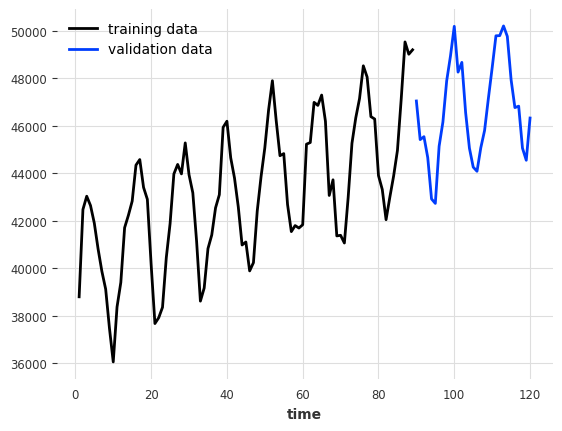

In [48]:
train, val = s_t_n.split_before(0.75)
train.plot(label = 'training data')
val.plot(label = 'validation data')

# Decompose training timeseries using STL

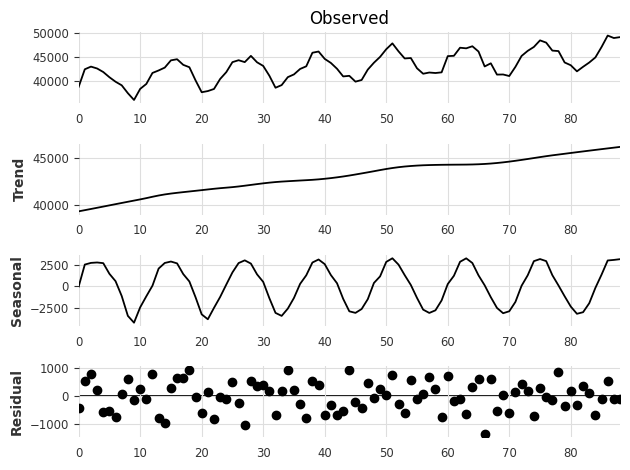

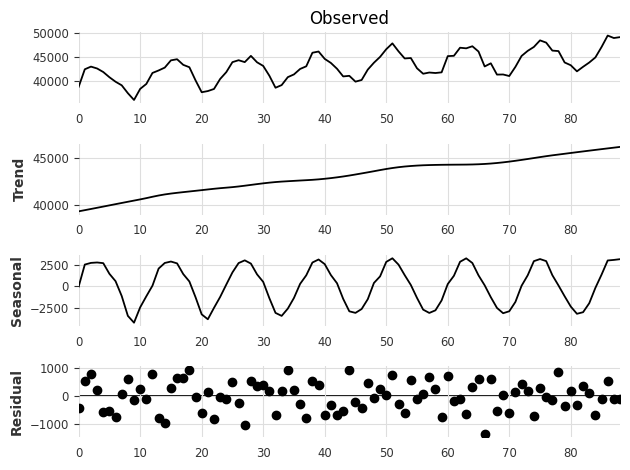

In [49]:
decomp = STL(train.values(), period = 12).fit()
decomp.plot()

# Create block bootstrap Samples

In [68]:
#Extract resids
resids = decomp.resid
l = 12
n = len(resids)
num_blocks = n - l
blocks_ls = []
for i in range(num_blocks + 1):
    end = i + l
    curr_block = resids[i:end]
    blocks_ls.append(curr_block)


# Create time series from bootstrap samples

In [92]:
samples = 200 # number os time series
num_blocks = int(n/l + 1) #number of blocks needed
new_ts = []
for i in range(samples):
    #Sample ts blocks
    curr_blocks = sample(blocks_ls, num_blocks)
    new_series = np.concatenate(curr_blocks)[0:n]

    #Add back trend and seasonal component
    new_series = new_series + decomp.trend + decomp.seasonal
    new_ts.append(new_series)

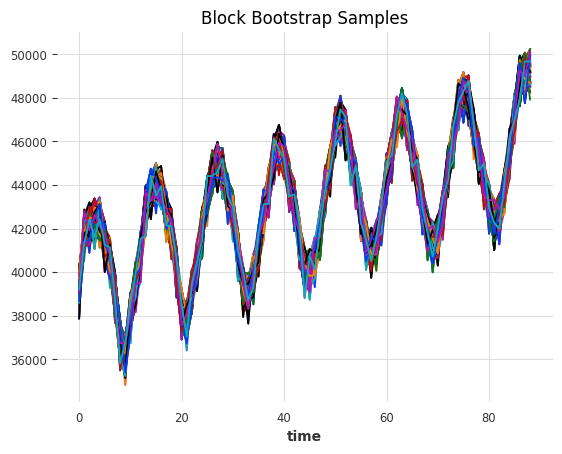

In [ ]:
plt.plot(np.vstack(new_ts).T)
plt.title("Block Bootstrap Samples")
plt.xlabel('time')
plt.show()

# Make forecasts

In [118]:
pred_ls = []
for i in range(samples):
    train_ts = TimeSeries.from_values(new_ts[i])
    curr_ets = ExponentialSmoothing()
    curr_ets.fit(train_ts)
    preds = curr_ets.predict(len(val))
    pred_ls.append(preds.values().flatten())

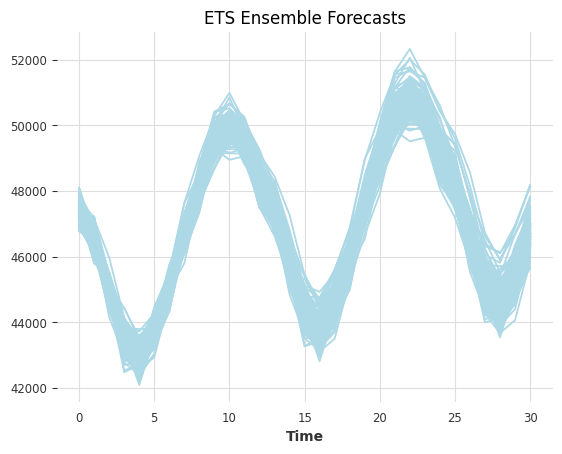

In [129]:
plt.plot(np.vstack(pred_ls).T, color = 'lightblue')
plt.title('ETS Ensemble Forecasts')
plt.xlabel('Time')
plt.show()

# Calculat ensemble mean

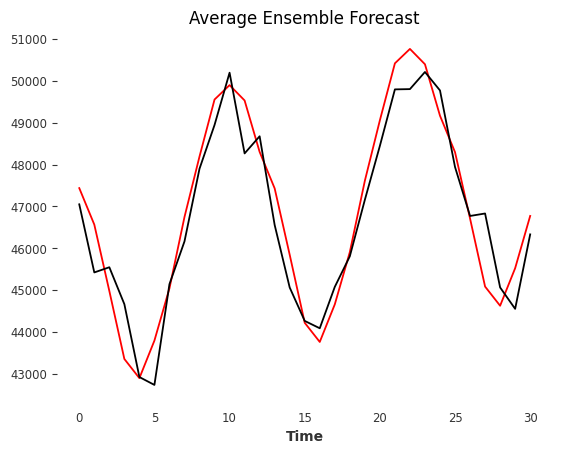

In [133]:
plt.plot(np.vstack(pred_ls).T.mean(axis=1), color = 'red')
plt.plot(val.values().flatten(), color = 'black')
plt.title('Average Ensemble Forecast')
plt.xlabel('Time')
plt.grid(visible=False)
plt.show()

# Visual

In [144]:
%matplotlib qt

In [205]:
#define np arrays
pred_array = np.vstack(pred_ls).T
samples_array = np.vstack(new_ts).T
#Set up figure
plt.figure(figsize = (10, 5))
ax1 = plt.subplot(121)
ax1.grid(visible=False)
ax1.set_xlabel('Time Index')
ax1.title.set_text('Block Bootstap Training Samples')
ax2 = plt.subplot(122)
ax2.grid(visible=False)
ax2.set_xlabel('Time Index')
ax2.title.set_text('Exponential Smoothing Ensemble Forecasts')

In [206]:
for i in range(samples):
    ax1.plot(samples_array[:,i])
    ax2.plot(pred_array[:,i], color = 'lightgray', label= 'Ensemble Forecasts' if 'Ensemble Forecasts' \
            not in plt.gca().get_legend_handles_labels()[1] else '')
    ax2.plot(val.values().flatten(), color = 'green',  label= 'Validation Set' if 'Validation Set' \
            not in plt.gca().get_legend_handles_labels()[1] else '')
    ax2.plot(pred_array[:,0:i].mean(axis = 1), color = 'blue',  label= 'Mean of Ensemble Forecast' if 'Mean of Ensemble Forecast' \
            not in plt.gca().get_legend_handles_labels()[1] else '')
    ax2.legend(loc = 'upper left')
    plt.pause(0.01)


C:\Users\steve\AppData\Local\Temp\ipykernel_23868\2464061637.py:7: RuntimeWarning: Mean of empty slice.
  ax2.plot(pred_array[:,0:i].mean(axis = 1), color = 'blue',  label= 'Mean of Ensemble Forecast' if 'Mean of Ensemble Forecast' \
